# Trabajo Práctico N°4: NLP
## Predicción de palabra siguiente

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Se utilizó inicialmente el libro Harry Potter y la Piedra Filosofal para la generación de modelos. Al ver pobres resultados con 2 configuraciones distintas en la arquitectura del modelo y con la intención de obtener una mejoría, se decidió agregar también al dataset el segundo libro de la saga, Harry Potter y la Cámara Secreta.


In [2]:
import re

# Leer el archivo como un solo string
with open('Harry Potter 1.txt', 'r') as f:
    texto = f.read()

# Reemplazar "\n\n" por "." y "\n" por " "
texto = texto.replace('\n\n', '. ').replace('\n', ' ')

# Eliminar los guiones, signos de exclamación, interrogación
texto = re.sub(r'[-—¡¿!?]', '', texto)

# Si quieres escribir el texto modificado a un nuevo archivo:
with open('Harry Potter 1_modificado.txt', 'w') as f:
    f.write(texto)

#Repito para el segundo libro
with open('Harry Potter y la Camara Secreta.txt', 'r') as f:
    texto = f.read()
texto = texto.replace('\n\n', '. ').replace('\n', ' ')
texto = re.sub(r'[-—¡¿!?]', '', texto)
with open('Harry Potter y la Camara Secreta_modificado.txt', 'w') as f:
    f.write(texto)

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Descarga el conjunto de stopwords de NLTK si aún no lo has hecho
nltk.download('stopwords')

# Descarga el tokenizador de NLTK si aún no lo has hecho
nltk.download('punkt')

# Cargar el tokenizador de oraciones español de NLTK
spanish_tokenizer = nltk.data.load('tokenizers/punkt/spanish.pickle')

# Carga las stopwords en español de NLTK
stop_words = set(stopwords.words('spanish'))

sentences = []
sentences_2 = []
sentences_no_stopwords = []

with open('Harry Potter 1_modificado.txt', 'r') as f:
    for line in f:
        line_sentences = spanish_tokenizer.tokenize(line)
        sentences.extend(line_sentences)
        

with open('Harry Potter y la Camara Secreta_modificado.txt', 'r') as f:
    for line in f:
        line_sentences = spanish_tokenizer.tokenize(line)
        sentences_2.extend(line_sentences)
        


# Convierte la lista de oraciones en un DataFrame
df = pd.DataFrame(sentences, columns=['sentence'])
df_2 = pd.DataFrame(sentences_2, columns=['sentence'])
df_extendido = pd.concat([df, df_2])



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
df.head()

,sentence
0,El niño que vivió.
1,"El señor y la señora Dursley, que vivían en el..."
2,Eran las últimas personas que se esperaría enc...
3,El señor Dursley era el director de una empres...
4,"Era un hombre corpulento y rollizo, casi sin c..."


In [5]:
df_2.head()

,sentence
0,"Tras derrotar una vez más a lord Voldemort, su..."
1,"Sin embargo, la espera dura poco, pues un elfo..."
2,"Así pues, Harry no se lo piensa dos veces y, a..."
3,Pero puede un aprendiz de mago defender la esc...
4,"A primera hora de la mañana, había despertado ..."


In [6]:
print("Cantidad de documentos en el primer libro:", df.shape[0])
print("Cantidad de documentos en el segundo libro:", df_2.shape[0])
print("Cantidad de documentos en el segundo libro:", df_extendido.shape[0])

Cantidad de documentos en el primer libro: 5840
Cantidad de documentos en el segundo libro: 5743
Cantidad de documentos en el segundo libro: 11583


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [7]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding
from keras.layers import Bidirectional

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [8]:
# Ejemplo de como transformar una oración a tokens usando keras
text1 = df.iloc[0,0]
text2 = df.iloc[1,0]
text1

'El niño que vivió.'

en text1, la oración tiene la misma cantidad de palabnras que train_len

In [9]:
text2

'El señor y la señora Dursley, que vivían en el número 4 de Privet Drive, estaban orgullosos de decir que eran muy normales, afortunadamente.'

In [10]:
tokens1 = text_to_word_sequence(text1) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens1

['el', 'niño', 'que', 'vivió']

In [11]:
tokens2 = text_to_word_sequence(text2) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens2

['el',
 'señor',
 'y',
 'la',
 'señora',
 'dursley',
 'que',
 'vivían',
 'en',
 'el',
 'número',
 '4',
 'de',
 'privet',
 'drive',
 'estaban',
 'orgullosos',
 'de',
 'decir',
 'que',
 'eran',
 'muy',
 'normales',
 'afortunadamente']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [12]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [13]:
# Demos un vistazo
sentence_tokens[:2]

[['el', 'niño', 'que', 'vivió'],
 ['el',
  'señor',
  'y',
  'la',
  'señora',
  'dursley',
  'que',
  'vivían',
  'en',
  'el',
  'número',
  '4',
  'de',
  'privet',
  'drive',
  'estaban',
  'orgullosos',
  'de',
  'decir',
  'que',
  'eran',
  'muy',
  'normales',
  'afortunadamente']]

In [14]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences1 = []
text_sequences2 = []

for i in range(train_len, len(tokens1)):
  seq = tokens1[i-train_len:i]
  text_sequences1.append(seq)

for i in range(train_len, len(tokens2)):
  seq = tokens2[i-train_len:i]
  text_sequences2.append(seq)

In [15]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences1

[]

In [16]:
text_sequences2

[['el', 'señor', 'y', 'la'],
 ['señor', 'y', 'la', 'señora'],
 ['y', 'la', 'señora', 'dursley'],
 ['la', 'señora', 'dursley', 'que'],
 ['señora', 'dursley', 'que', 'vivían'],
 ['dursley', 'que', 'vivían', 'en'],
 ['que', 'vivían', 'en', 'el'],
 ['vivían', 'en', 'el', 'número'],
 ['en', 'el', 'número', '4'],
 ['el', 'número', '4', 'de'],
 ['número', '4', 'de', 'privet'],
 ['4', 'de', 'privet', 'drive'],
 ['de', 'privet', 'drive', 'estaban'],
 ['privet', 'drive', 'estaban', 'orgullosos'],
 ['drive', 'estaban', 'orgullosos', 'de'],
 ['estaban', 'orgullosos', 'de', 'decir'],
 ['orgullosos', 'de', 'decir', 'que'],
 ['de', 'decir', 'que', 'eran'],
 ['decir', 'que', 'eran', 'muy'],
 ['que', 'eran', 'muy', 'normales']]

Se puede ver que para oraciones con train_len o menos palabras, nuestra secuencia quedará vacía y no se consideraran estas oraciones en el entrenamiento. Se podría mejorar achicando train_len, pero esto reduciría significativamente la ventana de contexto, resultando en un modelo peor.

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [17]:
tok = Tokenizer() 

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences1) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences1 = tok.texts_to_sequences(text_sequences1)

tok.fit_on_texts(text_sequences2) 
sequences2 = tok.texts_to_sequences(text_sequences2)

In [18]:
# Ahora sequences tiene los números "ID", largo 4
sequences1

[]

In [19]:
sequences2

[[3, 18, 16, 4],
 [18, 16, 4, 5],
 [16, 4, 5, 6],
 [4, 5, 6, 1],
 [5, 6, 1, 7],
 [6, 1, 7, 8],
 [1, 7, 8, 3],
 [7, 8, 3, 9],
 [8, 3, 9, 10],
 [3, 9, 10, 2],
 [9, 10, 2, 11],
 [10, 2, 11, 12],
 [2, 11, 12, 13],
 [11, 12, 13, 14],
 [12, 13, 14, 2],
 [13, 14, 2, 15],
 [14, 2, 15, 1],
 [2, 15, 1, 17],
 [15, 1, 17, 19],
 [1, 17, 19, 20]]

In [20]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

20


In [21]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

20


In [22]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'que': 1, 'de': 2, 'el': 3, 'la': 4, 'señora': 5, 'dursley': 6, 'vivían': 7, 'en': 8, 'número': 9, '4': 10, 'privet': 11, 'drive': 12, 'estaban': 13, 'orgullosos': 14, 'decir': 15, 'y': 16, 'eran': 17, 'señor': 18, 'muy': 19, 'normales': 20}


In [23]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'la': 4, 'el': 5, 'señor': 2, 'y': 3, 'señora': 4, 'dursley': 4, 'que': 8, 'vivían': 4, 'en': 4, 'número': 4, '4': 4, 'de': 8, 'privet': 4, 'drive': 4, 'estaban': 4, 'orgullosos': 4, 'decir': 4, 'eran': 3, 'muy': 2, 'normales': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [24]:
# Vistazo a las primeras filas
df.iloc[:15,0]

0                                    El niño que vivió.
1     El señor y la señora Dursley, que vivían en el...
2     Eran las últimas personas que se esperaría enc...
3     El señor Dursley era el director de una empres...
4     Era un hombre corpulento y rollizo, casi sin c...
5     La señora Dursley era delgada, rubia y tenía u...
6     Los Dursley tenían un hijo pequeño llamado Dud...
7     Los Dursley tenían todo lo que querían, pero t...
8     La señora Potter era hermana de la señora Durs...
9     Los Dursley se estremecían al pensar qué diría...
10    Sabían que los Potter también tenían un hijo p...
11    El niño era otra buena razón para mantener ale...
12    Nuestra historia comienza cuando el señor y la...
13    Pero nada había en aquel nublado cielo que sug...
14    El señor Dursley canturreaba mientras se ponía...
Name: sentence, dtype: object

In [25]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus_extendido = df_extendido.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]

In [26]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
tokens_extendido=text_to_word_sequence(corpus_extendido)


In [27]:
print("Cantidad de tokens en el corpus:", len(tokens))
print("Cantidad de tokens en el corpus con ambos libros:", len(tokens_extendido))

Cantidad de tokens en el corpus: 77991
Cantidad de tokens en el corpus con ambos libros: 169308


In [28]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

text_sequences_extendido = []
for i in range(train_len, len(tokens_extendido)):
  seq = tokens_extendido[i-train_len:i]
  text_sequences_extendido.append(seq)

In [29]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:10]

[['el', 'niño', 'que', 'vivió'],
 ['niño', 'que', 'vivió', 'el'],
 ['que', 'vivió', 'el', 'señor'],
 ['vivió', 'el', 'señor', 'y'],
 ['el', 'señor', 'y', 'la'],
 ['señor', 'y', 'la', 'señora'],
 ['y', 'la', 'señora', 'dursley'],
 ['la', 'señora', 'dursley', 'que'],
 ['señora', 'dursley', 'que', 'vivían'],
 ['dursley', 'que', 'vivían', 'en']]

In [30]:
# Proceso de tokenización
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[6, 521, 2, 4080],
 [521, 2, 4080, 6],
 [2, 4080, 6, 94],
 [4080, 6, 94, 4],
 [6, 94, 4, 3],
 [94, 4, 3, 127],
 [4, 3, 127, 76],
 [3, 127, 76, 2],
 [127, 76, 2, 4081],
 [76, 2, 4081, 7],
 [2, 4081, 7, 6],
 [4081, 7, 6, 657],
 [7, 6, 657, 745],
 [6, 657, 745, 1],
 [657, 745, 1, 623],
 [745, 1, 623, 624],
 [1, 623, 624, 89],
 [623, 624, 89, 2827],
 [624, 89, 2827, 1],
 [89, 2827, 1, 120]]

In [31]:
# Proceso de tokenización
tok_extendido = Tokenizer() 
tok_extendido.fit_on_texts(text_sequences_extendido) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences_extendido = tok_extendido.texts_to_sequences(text_sequences_extendido)


In [32]:
print("Cantidad de rows del dataset del primer libro:", len(sequences))
print("Cantidad de rows del dataset con ambos libros:", len(sequences_extendido))

Cantidad de rows del dataset del primer libro: 77987
Cantidad de rows del dataset con ambos libros: 169304


### 3 - Input y target

In [33]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(77987, 3)
(77987,)


In [34]:
arr_sequences_extendido = np.array(sequences_extendido)
x_data_extendido = arr_sequences_extendido[:,:-1]
y_data_int_extendido = arr_sequences_extendido[:,-1] # aún falta el oneHotEncoder

print(x_data_extendido.shape)
print(y_data_int_extendido.shape)

(169304, 3)
(169304,)


In [35]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'que',
 3: 'la',
 4: 'y',
 5: 'a',
 6: 'el',
 7: 'en',
 8: 'no',
 9: 'harry',
 10: 'se',
 11: 'un',
 12: 'los',
 13: 'con',
 14: 'lo',
 15: 'una',
 16: 'dijo',
 17: 'por',
 18: 'su',
 19: 'las',
 20: 'para',
 21: 'pero',
 22: 'había',
 23: 'del',
 24: 'ron',
 25: 'es',
 26: 'al',
 27: 'le',
 28: 'hagrid',
 29: 'estaba',
 30: 'era',
 31: 'más',
 32: 'si',
 33: 'como',
 34: 'qué',
 35: 'hermione',
 36: 'cuando',
 37: 'muy',
 38: 'me',
 39: 'algo',
 40: 'vez',
 41: 'te',
 42: 'él',
 43: 'sus',
 44: 'ya',
 45: 'todo',
 46: 'todos',
 47: 'mientras',
 48: 'snape',
 49: 'sobre',
 50: 'dumbledore',
 51: 'tenía',
 52: 'eso',
 53: 'hacia',
 54: 'tan',
 55: 'yo',
 56: 'está',
 57: 'dudley',
 58: 'sin',
 59: 'hasta',
 60: 'bien',
 61: 'malfoy',
 62: 'nunca',
 63: 'nada',
 64: 'podía',
 65: 'parecía',
 66: 'porque',
 67: 'ver',
 68: 'puerta',
 69: 'profesora',
 70: 'vernon',
 71: 'fue',
 72: 'tío',
 73: 'neville',
 74: 'quirrell',
 75: 'otra',
 76: 'dursley',
 77: 'ellos',
 78: 'allí'

In [36]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

8613

In [37]:
# Para el dataset extendido:
vocab_size_extendido = len(tok_extendido.word_counts)
vocab_size_extendido

14103

In [38]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(77987, 8613)

In [39]:
y_data_int_offset_extendido = y_data_int_extendido - 1
y_data_extendido = to_categorical(y_data_int_offset_extendido, num_classes=vocab_size_extendido) 
y_data_extendido.shape

(169304, 14103)

### 4 - Entrenar el modelo

In [40]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [41]:
input_seq_len_extendido = x_data_extendido.shape[1] 
input_seq_len_extendido

3

In [42]:
# Largo del vector de salida --> vocab_size
output_size_extendido = vocab_size_extendido
output_size_extendido

14103

In [43]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

8613

#### 3.1 - Probamos primero con el dataset solo del primer libro

In [ ]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              43070     
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 8613)              284229    
                                                                 
Total params: 380,323
Trainable params: 380,323
Non-trai

In [ ]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
1950/1950 [==============================] - 39s 15ms/step - loss: 6.9428 - accuracy: 0.0452 - val_loss: 6.8415 - val_accuracy: 0.0392
Epoch 2/50
1950/1950 [==============================] - 19s 9ms/step - loss: 6.5536 - accuracy: 0.0461 - val_loss: 6.8350 - val_accuracy: 0.0449
Epoch 3/50
1950/1950 [==============================] - 19s 10ms/step - loss: 6.3398 - accuracy: 0.0561 - val_loss: 6.8414 - val_accuracy: 0.0542
Epoch 4/50
1950/1950 [==============================] - 19s 10ms/step - loss: 6.1398 - accuracy: 0.0648 - val_loss: 6.8811 - val_accuracy: 0.0585
Epoch 5/50
1950/1950 [==============================] - 19s 10ms/step - loss: 6.0036 - accuracy: 0.0687 - val_loss: 6.9758 - val_accuracy: 0.0615
Epoch 6/50
1950/1950 [==============================] - 18s 9ms/step - loss: 5.8942 - accuracy: 0.0724 - val_loss: 7.0131 - val_accuracy: 0.0633
Epoch 7/50
1950/1950 [==============================] - 19s 10ms/step - loss: 5.7744 - accuracy: 0.0782 - val_loss: 7.0702 - v

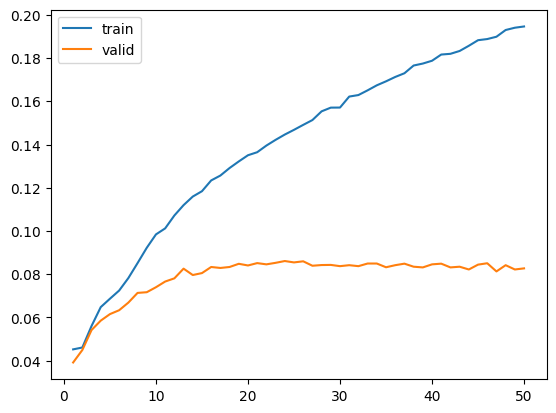

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

Se puede ver que las métricas resultantes no son buenas.
Probamos con redes bidireccionales.

In [ ]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

# Añadir una capa LSTM bidireccional
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))

# Añadir otra capa LSTM bidireccional
# No es necesario poner return_sequences=True porque la siguiente capa ya no es recurrente
model.add(Bidirectional(LSTM(64)))

model.add(Dense(32, activation='relu'))

model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 5)              43070     
                                                                 
 bidirectional (Bidirectiona  (None, 3, 128)           35840     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 3, 128)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 8613)             

In [ ]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
1950/1950 [==============================] - 41s 17ms/step - loss: 6.8620 - accuracy: 0.0454 - val_loss: 6.7486 - val_accuracy: 0.0392
Epoch 2/50
1950/1950 [==============================] - 26s 13ms/step - loss: 6.4015 - accuracy: 0.0475 - val_loss: 6.7514 - val_accuracy: 0.0508
Epoch 3/50
1950/1950 [==============================] - 27s 14ms/step - loss: 6.1750 - accuracy: 0.0634 - val_loss: 6.7915 - val_accuracy: 0.0619
Epoch 4/50
1950/1950 [==============================] - 25s 13ms/step - loss: 5.9822 - accuracy: 0.0751 - val_loss: 6.8477 - val_accuracy: 0.0672
Epoch 5/50
1950/1950 [==============================] - 25s 13ms/step - loss: 5.8001 - accuracy: 0.0851 - val_loss: 6.8878 - val_accuracy: 0.0748
Epoch 6/50
1950/1950 [==============================] - 25s 13ms/step - loss: 5.6279 - accuracy: 0.0970 - val_loss: 6.8951 - val_accuracy: 0.0780
Epoch 7/50
1950/1950 [==============================] - 24s 12ms/step - loss: 5.4736 - accuracy: 0.1073 - val_loss: 6.9139 -

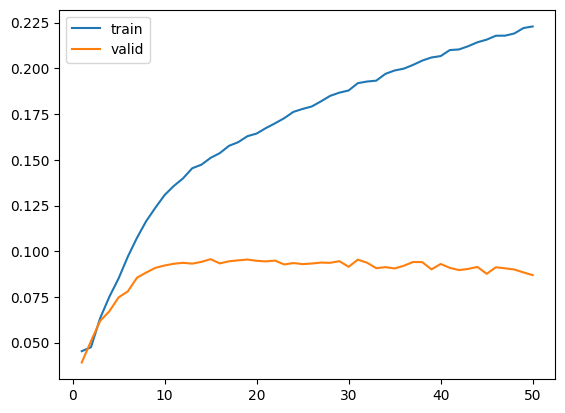

In [ ]:
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

#### 3.2 - Ahora generamos un modelo para el dataset extendido, con ambos libros, y agregando una LSTM más.

In [ ]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size_extendido+1, output_dim=7, input_length=input_seq_len_extendido))

# Añadir una capa LSTM bidireccional
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))

# Segunda capa LSTM bidireccional
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))

# Tercera capa LSTM bidireccional
model.add(Bidirectional(LSTM(64)))

model.add(Dense(32, activation='relu'))

model.add(Dense(vocab_size_extendido, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 7)              98728     
                                                                 
 bidirectional (Bidirectiona  (None, 3, 128)           36864     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 3, 128)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 3, 128)           98816     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 3, 128)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              9

In [ ]:
import tensorflow as tf

In [ ]:
with tf.device('/CPU:0'):
    hist = model.fit(x_data_extendido, y_data_extendido, epochs=50, validation_split=0.2)

Epoch 1/50
4233/4233 [==============================] - 111s 24ms/step - loss: 6.8140 - accuracy: 0.0489 - val_loss: 6.6455 - val_accuracy: 0.0630
Epoch 2/50
4233/4233 [==============================] - 102s 24ms/step - loss: 6.3120 - accuracy: 0.0701 - val_loss: 6.5830 - val_accuracy: 0.0805
Epoch 3/50
4233/4233 [==============================] - 99s 23ms/step - loss: 5.9992 - accuracy: 0.0915 - val_loss: 6.5789 - val_accuracy: 0.0938
Epoch 4/50
4233/4233 [==============================] - 99s 23ms/step - loss: 5.7669 - accuracy: 0.1064 - val_loss: 6.5713 - val_accuracy: 0.1031
Epoch 5/50
4233/4233 [==============================] - 99s 23ms/step - loss: 5.5836 - accuracy: 0.1171 - val_loss: 6.6249 - val_accuracy: 0.1053
Epoch 6/50
4233/4233 [==============================] - 97s 23ms/step - loss: 5.4446 - accuracy: 0.1258 - val_loss: 6.6730 - val_accuracy: 0.1093
Epoch 7/50
4233/4233 [==============================] - 98s 23ms/step - loss: 5.3329 - accuracy: 0.1333 - val_loss: 6.7262

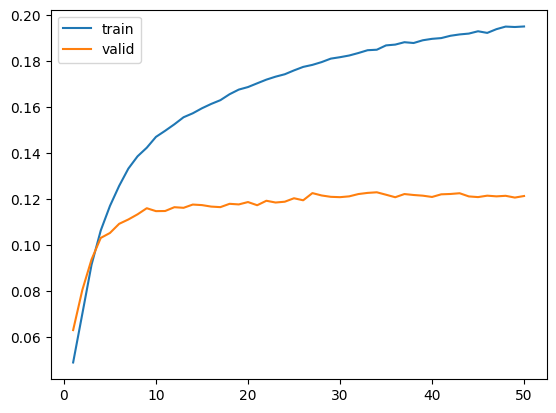

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

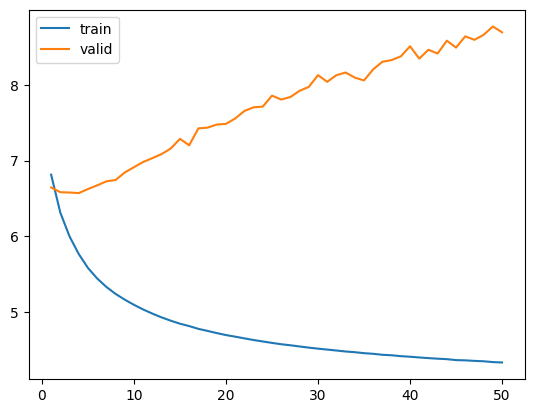

In [ ]:
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_loss'], label='valid')
plt.show()

Mejora un poco comparando con los modelos anteriores, pero en las primeras épocas ya comienza a tender al overfitting.

In [ ]:
import pickle
pickle.dump(tok_extendido, open('tokenizador_extendido.pkl','wb'))
model.save('modelo_prediccion_hp.h5')

In [44]:
import pickle
tok_extendido = None
with open('/content/tokenizador_extendido.pkl', 'rb') as f:
    # Usa pickle.load para cargar los datos
    tok_extendido = pickle.load(f)


In [45]:
from keras.models import load_model

# Carga el modelo
model = load_model('/content/modelo_prediccion_hp.h5')

In [46]:
tok_extendido

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [47]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 80.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.1/288.1 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.8 MB/s eta 0:0

In [48]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok_extendido.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok_extendido.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

<ipython-input-48-cf0b37433377>:24: UserWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 21ms/step
Keyboard interruption in main thread... closing server.


Outputs (4ta palabra):
- hogwarts es una sólo
- harry potter es no
- harry ron y si
- es la profesora habían

### 6 - Generación de secuencias nuevas

In [49]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [50]:
input_text='harry es un'

generate_seq(model, tok_extendido, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 20ms/step


'harry es un sólo '

In [51]:
input_text='hogwarts es una'

generate_seq(model, tok_extendido, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 31ms/step


'hogwarts es una sólo voló'

In [52]:
input_text='la lechuza hedwig'

generate_seq(model, tok_extendido, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 24ms/step


'la lechuza hedwig harry harry'

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting, aún cuando se probaron distintas configuraciones de cantidad de vocabulario, redes recurrentes, y embeddings. Sin embargo en las métricas del último modelo se pudo apreciar una pequeña mejoría que indica que el modelo podría optimizarse aumentando ampliamente el dataset, quizás usando la saga entera de libros de Harry Potter.